# Introduction
This notebook is for the workshop presented at the AWOC/KJWOC 2024.

## Abstract
This training course covers the basic handling of SGLI products using python in the following sequence.

1. reading data from hdf5 files and converting to geophysical quantities  
2. Quality control of satellite data using QA flags  
3. Map projection to equirectangular coordinates

## Prerequisites
* It is recommended that attendees have a basic understanding of Python and Jupyter Notebook.

# Import libraries
Import the hdf5 and matplotlib libraries required for map projection of SGLI images.

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Target file specification
Specify the path to the target file.  
Try out some other sample data in the folder later.  
In this case, select the SST image.  

In [16]:
FNAME = 'SGLI_sample/GC1SG1_201809050115H04610_L2SG_SSTDQ_3001.h5'

# Check the structure of the hdf5 file
The hierarchical structure of HDF5 is similar to that of computers.  
However, the names of each element are different, as shown in the table below.   
<img src="figures_for_markdown/hdfファイル構造概要_en.png" width="50%">  
Check the data structure of the SGLI hdf5 file using python.

In [17]:
def PrintAllObjects(name):
    print(name)

with h5py.File(FNAME,'r') as f:
    f.visit(PrintAllObjects)

Geometry_data
Geometry_data/Latitude
Geometry_data/Longitude
Geometry_data/Obs_time
Geometry_data/Sensor_zenith
Geometry_data/Solar_zenith
Global_attributes
Image_data
Image_data/Cloud_probability
Image_data/Line_tai93
Image_data/QA_flag
Image_data/SST
Level_1_attributes
Processing_attributes


また、昨日紹介したhdfview( https://www.hdfgroup.org/download-hdfview/ )でも確認可能です。  
<img src="figures_for_markdown/hdfファイル構造.png" width="50%">  

# dataname specification
Specify the datename you wish to plot.  
The full path, including the hdf5 hierarchy group, must be properly specified.  
If you want to show SST, specify ‘/Image_data/SST’.  

In [4]:
DNAME = '/Image_data/SST'

# Load data.
Load the target data immediately and illustrate.  

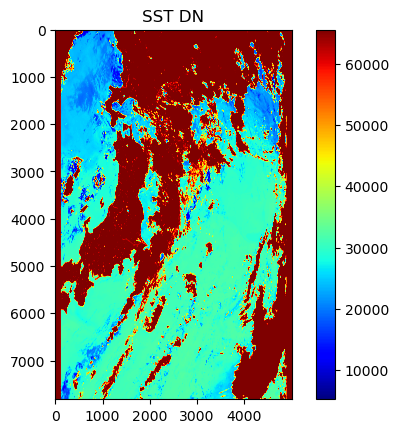

In [5]:
with h5py.File(FNAME, 'r') as file:
    # Read SST data
    Data0 = file[DNAME][:]
    
fig, ax = plt.subplots()
plt.imshow(Data0, cmap='jet')
ax.set_title("SST DN")
plt.colorbar()
#plt.savefig("DN.png", format="png", dpi=2000)
plt.show()

# Conversion from DN to physical quantity
Each physical quantity is stored as an integer value from 0-65535 for data compression purposes (Digital Number = DN).  
To convert a DN into a physical quantity, the necessary constants must be read from the attribute associated with each physical quantity and calculated.
  
## Checking the attribute
The attribute set for each dataset can be checked below.

In [6]:
with h5py.File(FNAME,'r') as file:
    dset = file[DNAME].attrs
    for k in dset.keys():
        print(k)

Cloud_error_DN
Data_description
Dim0
Dim1
Error_DN
Land_DN
Mask_for_statistics
Maximum_valid_DN
Minimum_valid_DN
Offset
Retrieval_error_DN
Slope
Spatial_resolution
Spatial_resolution_unit
Unit


Check with hdfview.    
<img src="figures_for_markdown/attribute.png" width="100%">  

## Conversion from DN to physical quantity
For the physical quantity conversion of SGLI data, [**slope**] and [**offset**] must be read and calculated as follows.  
**[physical quantity] = [DN]*[slope]+[offset]**  
  
Also, use [**ErrorDN**] and [**Minimum_valid_DN**], [**Maximum_valid_DN**] to remove invalid pixels before DN conversion.  

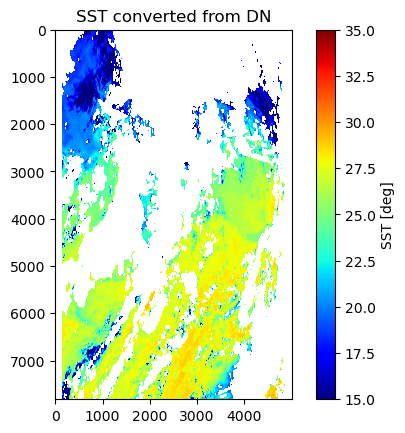

In [7]:
with h5py.File(FNAME, 'r') as file:
    # Read DN
    Data0 = file[DNAME][:]
    
    # Read attributes
    Err_DN = file[DNAME].attrs['Error_DN']
    Min_DN = file[DNAME].attrs['Minimum_valid_DN']
    Max_DN = file[DNAME].attrs['Maximum_valid_DN']
    Slope  = file[DNAME].attrs['Slope']
    Offset = file[DNAME].attrs['Offset']

    # Removal of invalid pixels and physical quantity conversion.
    Data1 = Data0.astype(float)
    Data1[Data0 == Err_DN] = np.nan
    Data1[(Data0 <= Min_DN) | (Data0 >= Max_DN)] = np.nan
    Data1 = Slope * Data1 + Offset
    
fig, ax = plt.subplots()
plt.imshow(Data1, cmap='jet', vmin=15, vmax=35)
ax.set_title("SST converted from DN")
plt.colorbar(label='SST [deg]')
plt.show()

# Satellite data quality control with QA_flag
## QA_flag overview
For SGLI data, a QA flag is set for each pixel to indicate its quality.  
Screening using the QA flag allows only data of the desired quality to be extracted.  
  
The QA flags are stored in DN (0-65535) and the flag corresponding to the value of each bit when viewed as a binary number (type uint16) is set.  
Example) 16-bit unsigned integer type: 1928 in decimal  
<img src="figures_for_markdown/bit説明.png" width="70%">   
  
Now let's check the contents of the flags corresponding to each bit of QA_flag.

In [8]:
with h5py.File(FNAME,'r') as file:
    qa_flag_data_description = file['/Image_data/QA_flag'].attrs['Data_description']
    qa_string = qa_flag_data_description.astype(str)
    qa_string = ",".join(qa_string)
    qa_string = qa_string.replace(',', '\n')
    print(qa_string)

Bit-0:invalid data
1:land
2:Rejected by QC
3:retrieval error
4:invalid data(TIR1)
5:invalid data(TIR2)
6-7:reserved
8:0:nighttime or no visible data
1:daytime
9:near land
10:cloudy
11:unknown clear/cloudy
12:possibly cloudy
 13:acceptable
14:good
15:reserved


Information on QA_flag can also be found on the official GCOM-C website.（https://suzaku.eorc.jaxa.jp/GCOM_C/data/update/Algorithm_SST_ja.html）
<img src="figures_for_markdown/sst_qa_flag.png" width="70%"> 

## Each bit of the QA_flag is illustrated below.

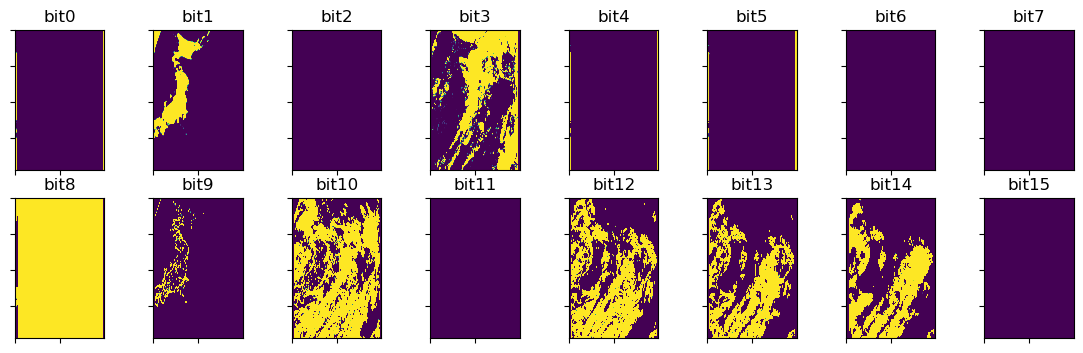

In [9]:
with h5py.File(FNAME, 'r') as file:
    QA_flag = file['/Image_data/QA_flag'][:]
    fig = plt.figure(figsize=(14.0, 4.0))    
    for i in range(16):
        qa_flag_bit = np.bitwise_and(QA_flag, 2**i, dtype=np.uint16)
        ax = fig.add_subplot(2, 8, i+1)
        ax.set_title("bit"+ str(i))
        im = ax.imshow(qa_flag_bit, vmin=0, vmax=1)
        ax.tick_params(labelbottom=False, labelleft=False)

## Applying the QA_flag
This time, only pixels where [**good**], [**acceptable**] and [**possibly_cloudy**] stand will be illustrated.

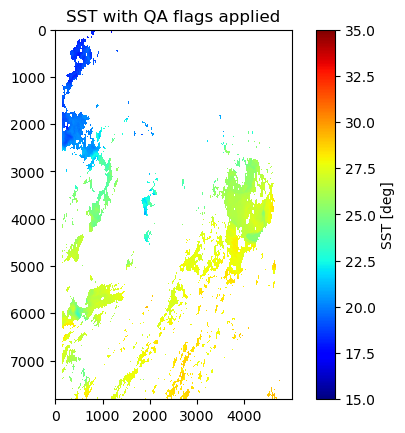

In [10]:
with h5py.File(FNAME, 'r') as file:
    
    # Read QA_flag
    QA_flag = file['/Image_data/QA_flag'][:]
    possibly_cloudy = np.bitwise_and(QA_flag, 2**12, dtype=np.uint16)
    acceptable = np.bitwise_and(QA_flag, 2**13, dtype=np.uint16)
    good = np.bitwise_and(QA_flag, 2**14, dtype=np.uint16)

    reliable = np.logical_or.reduce([good, acceptable, possibly_cloudy])

    # Apply reliability mask
    Data1[~reliable] = np.nan

    # Plotting with reliability mask
    fig, ax = plt.subplots()
    plt.imshow(Data1, cmap='jet', vmin=15, vmax=35)
    ax.set_title("SST with QA flags applied")
    plt.colorbar(label='SST [deg]')
    plt.show()

# Conversion to latitude and longitude coordinates
Polar-orbiting satellite SGLI images are provided just as scanned by the satellite (Scene).  
In order to map project them to latitude and longitude coordinates, a 2D interpolation must be performed to transform the coordinates.  
<img src="figures_for_markdown/SGLI_スキャン概念図.png" width="80%"> 

## Loading latitude and longitude information
The SGLI latitude and longitude information is stored in 10-pix thinning (Resampling_interval), so it must first be interpolated to the same resolution as the physical quantity.

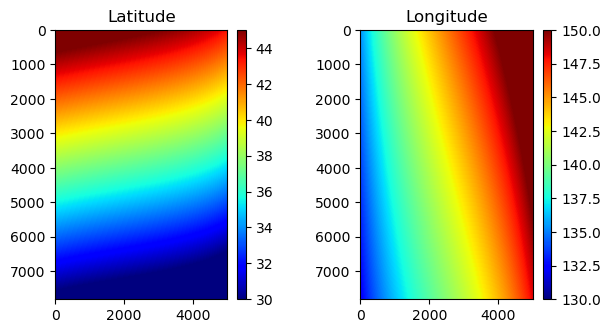

In [11]:
with h5py.File(FNAME, 'r') as file:
    # Read Latitude and Longitude
    Lat = file['/Geometry_data/Latitude'][:]
    Lat_r = float(file['/Geometry_data/Latitude'].attrs['Resampling_interval'])
    Lon = file['/Geometry_data/Longitude'][:]
    Lon_r = float(file['/Geometry_data/Longitude'].attrs['Resampling_interval'])

    # Create meshgrid
    X, Y = np.meshgrid(np.arange(1, Lat_r * Lat.shape[1] + 1, Lat_r),
                       np.arange(1, Lat_r * Lat.shape[0] + 1, Lat_r))

    Xq, Yq = np.meshgrid(np.arange(1, Data0.shape[1] + 1),
                         np.arange(1, Data0.shape[0] + 1))

    # Interpolate Latitude and Longitude
    f_lat = griddata((X.flatten(), Y.flatten()), Lat.flatten(), (Xq, Yq), method='linear')
    f_lon = griddata((X.flatten(), Y.flatten()), Lon.flatten(), (Xq, Yq), method='linear')

    LLroi = {'Lat': f_lat,
             'Lon': f_lon}
    
    # Plotting
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.6,hspace=0.6)
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Latitude")
    im1 = ax1.imshow(LLroi['Lat'], vmin=30, vmax=45, cmap='jet')
    plt.gca().set_aspect('equal', adjustable='box')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title("Longitude")
    im2 = ax2.imshow(LLroi['Lon'], vmin=130, vmax=150, cmap='jet')
    plt.gca().set_aspect('equal', adjustable='box')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im2, cax=cax) 

## Cut out target area
Cut out the target area for map projection.  
In this case, the target area is Tokyo Bay.(red box)  
<img src="figures_for_markdown/SST_without_QC_tokyo_bay.png" width="50%">

In [12]:
# Indexing
IDX_X = slice(4600, 4900)
IDX_Y = slice(1550, 1750)

LLroi['Lat'] = LLroi['Lat'][IDX_X, IDX_Y]
LLroi['Lon'] = LLroi['Lon'][IDX_X, IDX_Y]
Data1 = Data1[IDX_X, IDX_Y]

## Set resolution after map projection
Create a grid after map projection. Here, try map projection at **0.0025 [deg]** intervals.

In [13]:
# ROI calculation
DDeg = 0.0025
ROI = {'LatLim': [np.min(LLroi['Lat']), np.max(LLroi['Lat'])],
       'LonLim': [np.min(LLroi['Lon']), np.max(LLroi['Lon'])]}

Latg = np.arange(ROI['LatLim'][1], ROI['LatLim'][0] - DDeg, -DDeg)
Long = np.arange(ROI['LonLim'][0], ROI['LonLim'][1] + DDeg, DDeg)

LLg = np.meshgrid(Latg, Long, indexing='ij')

## Projection to latitude and longitude coordinates
Map projection using python functions

In [14]:
# Scattered interpolation
points = np.column_stack((LLroi['Lat'].flatten(), LLroi['Lon'].flatten()))
values = Data1.flatten()

grid_lat, grid_lon = np.meshgrid(Latg, Long, indexing='ij')
grid_points = np.column_stack((grid_lat.flatten(), grid_lon.flatten()))

Data2 = griddata(points, values, grid_points, method='linear').reshape(grid_lat.shape)

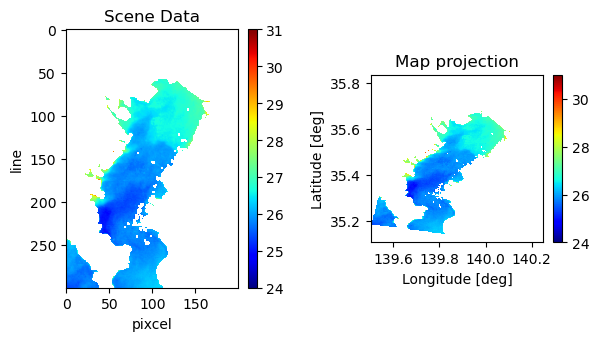

In [15]:
# Plotting
fig = plt.figure()
plt.subplots_adjust(wspace=0.6,hspace=0.6)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Scene Data")
plt.xlabel('pixcel')
plt.ylabel('line')
im1 = ax1.imshow(Data1, vmin=24, vmax=31, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Map projection")
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
im2 = ax2.pcolormesh(Long, Latg, Data2, vmin=24, vmax=31, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax)